In [1]:
%matplotlib inline

In [2]:
# Import necessary libraries
import pandas as pd
from datasets import load_dataset
import re
import unicodedata
import contractions
import nltk
from collections import Counter
from textstat import flesch_reading_ease, syllable_count
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize NLTK tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Text Cleaning
def clean_text(text):
    text = unicodedata.normalize("NFKD", text)  # Normalize Unicode
    text = contractions.fix(text)  # Expand contractions (e.g., "don't" → "do not")
    text = re.sub(r'[^a-zA-Z.,!?; ]+', '', text)  # Keep only letters & punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text.lower()  # Convert to lowercase

# Tokenization & Lemmatization
def preprocess_text(text):
    words = nltk.word_tokenize(text)  # Tokenization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Remove stopwords & lemmatize
    return " ".join(words)

[nltk_data] Downloading package punkt to /Users/dj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/dj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Get the dataset from Hello-SimpleAI/HC3
dataset = load_dataset("Hello-SimpleAI/HC3", "all")
df = pd.DataFrame(dataset["train"])

# Take a look at the dataset
df.head()

,id,question,human_answers,chatgpt_answers,source
0,0,"Why is every book I hear about a "" NY Times # ...","[Basically there are many categories of "" Best...",[There are many different best seller lists th...,reddit_eli5
1,1,"If salt is so bad for cars , why do we use it ...",[salt is good for not dying in car crashes and...,[Salt is used on roads to help melt ice and sn...,reddit_eli5
2,2,Why do we still have SD TV channels when HD lo...,[The way it works is that old TV stations got ...,[There are a few reasons why we still have SD ...,reddit_eli5
3,3,Why has nobody assassinated Kim Jong - un He i...,[You ca n't just go around assassinating the l...,[It is generally not acceptable or ethical to ...,reddit_eli5
4,4,How was airplane technology able to advance so...,[Wanting to kill the shit out of Germans drive...,[After the Wright Brothers made the first powe...,reddit_eli5


In [5]:
# Combine the human answers and chatgpt answers into one column
df = df.melt(value_vars=["human_answers", "chatgpt_answers"], var_name="original_column", value_name="text")

# Classify the human answers as 1 and the chatgpt answers as 0
df['classification'] = df['original_column'].apply(lambda x: 1 if x == 'human_answers' else 0)

# Drop the original column
df = df.drop(columns=['original_column']).reset_index(drop=True)

# Take a look at the dataset
df.head()

,text,classification
0,"[Basically there are many categories of "" Best...",1
1,[salt is good for not dying in car crashes and...,1
2,[The way it works is that old TV stations got ...,1
3,[You ca n't just go around assassinating the l...,1
4,[Wanting to kill the shit out of Germans drive...,1


In [6]:
# Get the summary of the dataset
df.shape

(48644, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48644 entries, 0 to 48643
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            48644 non-null  object
 1   classification  48644 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 760.2+ KB


In [8]:
# Convert lists to strings
df['text'] = df['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

print(df.head())

                                                text  classification
0  Basically there are many categories of " Best ...               1
1  salt is good for not dying in car crashes and ...               1
2  The way it works is that old TV stations got a...               1
3  You ca n't just go around assassinating the le...               1
4  Wanting to kill the shit out of Germans drives...               1


In [9]:
# Apply text cleaning
df["text"] = df["text"].apply(lambda x: clean_text(x) if isinstance(x, str) else x)

# Compute word count after text cleaning
df["word_count_cleaned"] = df["text"].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)

# Print dataset with word count after text cleaning
print("After Text Cleaning:")
print(df[["text", "word_count_cleaned"]].head())

After Text Cleaning:
                                                text  word_count_cleaned
0  basically there are many categories of best se...                 239
1  salt is good for not dying in car crashes and ...                 407
2  the way it works is that old tv stations got a...                 436
3  you ca nt just go around assassinating the lea...                 196
4  wanting to kill the shit out of germans drives...                 282


In [10]:
# Apply tokenization & lemmatization
df["text"] = df["text"].apply(lambda x: preprocess_text(x) if isinstance(x, str) else x)

# Compute word count after tokenization & lemmatization
df["word_count_lemmatized"] = df["text"].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)

# Print dataset with word count after tokenization & lemmatization
print("After Tokenization & Lemmatization:")
print(df[["text", "word_count_lemmatized"]].head())

After Tokenization & Lemmatization:
                                                text  word_count_lemmatized
0  basically many category best seller . replace ...                    142
1  salt good dying car crash car crash worse car ...                    233
2  way work old tv station got certain amount ban...                    270
3  ca nt go around assassinating leader country n...                    122
4  wanting kill shit german drive innovation . fr...                    160


In [11]:
# Extract word count
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)

# Extract sentence count
df["sentence_count"] = df["text"].apply(lambda x: len(nltk.sent_tokenize(x)) if isinstance(x, str) else 0)

# Compute average sentence length
df["avg_sentence_length"] = df["word_count"] / (df["sentence_count"] + 1)  # Avoid division by zero

# Compute punctuation count
df["punctuation_count"] = df["text"].apply(lambda x: len(re.findall(r'[.,!?;]', x)) if isinstance(x, str) else 0)

# Compute readability score
df["readability_score"] = df["text"].apply(lambda x: flesch_reading_ease(x) if isinstance(x, str) else 0)

# Compute unique word ratio (use set to remove duplicate)
df["unique_word_ratio"] = df["text"].apply(lambda x: len(set(x.split())) / len(x.split()) if isinstance(x, str) and len(x.split()) > 0 else 0)

# Compute text complexity
df["avg_word_length"] = df["text"].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if isinstance(x, str) and len(x.split()) > 0 else 0)
df["avg_syllables_per_word"] = df["text"].apply(lambda x: syllable_count(x) / len(x.split()) if isinstance(x, str) and len(x.split()) > 0 else 0)

In [12]:
# Extract n-grams (bigrams & trigrams)
def get_ngram_frequencies(text, n=2):
    words = text.split()
    ngrams = zip(*[words[i:] for i in range(n)])
    return Counter(ngrams).most_common(10)

df["bigrams"] = df["text"].apply(lambda x: get_ngram_frequencies(x, 2))
df["trigrams"] = df["text"].apply(lambda x: get_ngram_frequencies(x, 3))

In [13]:
# Compute sentiment analysis
df["sentiment_polarity"] = df["text"].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else 0)
df["sentiment_subjectivity"] = df["text"].apply(lambda x: TextBlob(x).sentiment.subjectivity if isinstance(x, str) else 0)

In [14]:
# Compute TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_features = vectorizer.fit_transform(df["text"]).toarray()

In [15]:
print(df.head())
print(f"Total words in dataset: {df['word_count'].sum()}")

                                                text  classification  \
0  basically many category best seller . replace ...               1   
1  salt good dying car crash car crash worse car ...               1   
2  way work old tv station got certain amount ban...               1   
3  ca nt go around assassinating leader country n...               1   
4  wanting kill shit german drive innovation . fr...               1   

   word_count_cleaned  word_count_lemmatized  word_count  sentence_count  \
0                 239                    142         142              13   
1                 407                    233         233              22   
2                 436                    270         270              15   
3                 196                    122         122              11   
4                 282                    160         160              11   

   avg_sentence_length  punctuation_count  readability_score  \
0            10.142857                 23     

## Initial experimentation

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

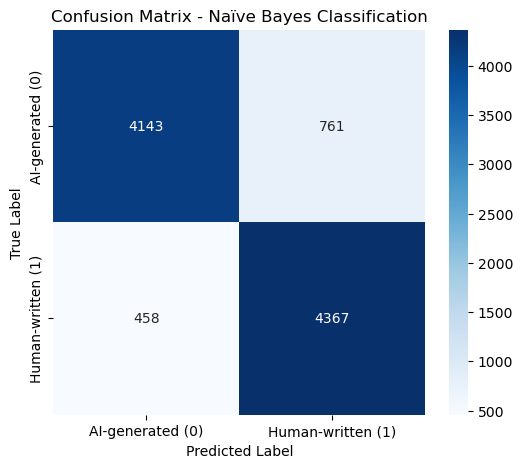

[[4143  761]
 [ 458 4367]]
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      4904
           1       0.85      0.91      0.88      4825

    accuracy                           0.87      9729
   macro avg       0.88      0.87      0.87      9729
weighted avg       0.88      0.87      0.87      9729



In [17]:
# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(df["text"])  # Feature matrix
y = df["classification"]  # Labels (1 = Human, 0 = AI)

# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Naïve Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions
y_pred = nb_classifier.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ["AI-generated (0)", "Human-written (1)"]

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Naïve Bayes Classification")
plt.show()

# Convert classification report to a DataFrame
report = classification_report(y_test, y_pred, target_names=["AI-generated (0)", "Human-written (1)"], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Display results in a formatted table
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))